In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

# 1 Load libraries and parameters

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns
sns.set_theme(style="darkgrid")

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug
import tfds_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
params['model_dirs'] = {
    'BL_RIV2_test4': ['/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_RIV2_test4', 'CNN_Structure'],
    'BL_RIV2_test8': ['/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_RIV2_test8', 'CNN_Color_Structure'],
    'LM_RIV2_test7': ['/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/LM_RIV2_test7', 'LM_Structure'],
    'LM_RIV2_test4': ['/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/LM_RIV2_test4', 'LM_Color'],
}
params['lin_model_dirs'] = {
    'LM_RIV2_test7': ['/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/LM_RIV2_test7', 'Coef_LM_Structure'],
    'LM_RIV2_test4': ['/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/LM_RIV2_test4', 'Coef_LM_Color'],
}
params['CMA'] = 'CMA_0'
params['tf_ds_name'] = 'mpp_ds_normal_dmso_z_score'
params['local_tf_datasets'] = '/data/Master_Thesis_data/datasets/tensorflow_datasets'

params['cells'] = ['258520', '208516', '262920', '307720']
params['score_maps_path'] = '/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/BL_RIV2_test4'
params['score_maps_path_lm_t4'] = '/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/LM_RIV2_test4'
params['score_maps_path_lm_t7'] = '/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/LM_RIV2_test7'



plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# Notas
- BL_t8 mide 08_H3K4ME3 usando 09_SRRM2
- It looks like cell 277420 is 2 overlaped cells.

## 2 Load dataset

In [4]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=params['tf_ds_name'], 
    data_dir=params['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

# Load splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [5]:
ds_info.splits

{'test': <SplitInfo num_examples=371, num_shards=32>,
 'train': <SplitInfo num_examples=2962, num_shards=256>,
 'validation': <SplitInfo num_examples=370, num_shards=32>}

In [6]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [7]:
metadata_df = tfds_metadata['metadata_df']
metadata_df.mapobject_id_cell = metadata_df.mapobject_id_cell.astype(str)
metadata_df

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
0               263042        263055    plate01       J16           0   
1               263043        263056    plate01       J16           0   
2               263044        263057    plate01       J16           0   
3               263045        263058    plate01       J16           0   
4               263047        263060    plate01       J16           0   
...                ...           ...        ...       ...         ...   
3698            266516        266565    plate01       J12           5   
3699            266518        266567    plate01       J12           5   
3700            266519        266568    plate01       J12           5   
3701            266520        266569    plate01       J12           5   
3702            266521        266570    plate01       J12           5   

      well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
0              0       0       0      4          0         plate01   
1              0       0       0      5          0         plate01   
2              0       0       0      6          0         plate01   
3              0       0       0      7          0         plate01   
4              0       0       0      9          0         plate01   
...          ...     ...     ...    ...        ...             ...   
3698           4       0       0     44          0         plate01   
3699           4       0       0     46          0         plate01   
3700           4       0       0     47          0         plate01   
3701           4       0       0     48          0         plate01   
3702           4       0       0     49          0         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
0               J16                0                0            0   
1               J16                0                0            0   
2               J16                0                0            0   
3               J16                0                0            0   
4               J16                0                0            0   
...             ...              ...              ...          ...   
3698            J12                5                4            0   
3699            J12                5                4            0   
3700            J12                5                4            0   
3701            J12                5                4            0   
3702            J12                5                4            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
0               0           4               0         0.0                NaN   
1               0           5               0         0.0                NaN   
2               0           6               0         0.0                NaN   
3               0           7               0         0.0                NaN   
4               0           9               0         0.0                NaN   
...           ...         ...             ...         ...                ...   
3698            0          44               0         0.0                NaN   
3699            0          46               0         0.0                NaN   
3700            0          47               0         0.0                NaN   
3701            0          48               0         0.0                NaN   
3702            0          49               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
0                    0.0                        NaN                  0.0   
1                    0.0                        NaN                  0.0   
2                    0.0                        NaN                  0.0   
3                    0.0                        NaN                  0.0   
4                    0.0                        NaN                  0.0   
...                  ...     

In [8]:
tfds_metadata['metadata_df'].shape

(3703, 69)

In [9]:
channels_df = tfds_metadata['channels_df']
channels_df

original_channel_id               name  train_98_percentile  \
0                   0.0            00_DAPI            69.300003   
1                   1.0             07_H2B           310.299988   
2                   2.0      01_CDK9_pT186            46.889076   
3                   3.0            03_CDK9            90.797798   
4                   4.0           05_GTF2B           188.166107   
5                   5.0          07_SETD1A            91.989853   
6                   6.0         08_H3K4me3           105.921074   
7                   7.0           09_SRRM2           273.374664   
8                   8.0         10_H3K27ac           175.104874   
9                   9.0       11_KPNA2_MAX           115.093430   
10                 10.0  12_RB1_pS807_S811           183.208527   
11                 11.0          13_PABPN1           396.026215   
12                 12.0            14_PCNA           146.451843   
13                 13.0             15_SON           243.390030   
14                 14.0              16_H3           439.498047   
15                 15.0           17_HDAC3           145.043106   
16                 16.0       19_KPNA1_MAX           146.208435   
17                 17.0           20_SP100           219.365936   
18                 18.0             21_NCL           201.973480   
19                 19.0          01_PABPC1            50.292484   
20                 20.0            02_CDK7           277.580566   
21                 21.0            03_RPS6            44.969013   
22                 22.0              05_Sm           104.192703   
23                 23.0          07_POLR2A           323.886353   
24                 24.0           09_CCNT1           201.454315   
25                 25.0      10_POL2RA_pS2           541.873108   
26                 26.0             11_PML            81.143768   
27                 27.0            12_YAP1           195.926712   
28                 28.0      13_POL2RA_pS5           445.722107   
29                 29.0        15_U2SNRNPB            85.901764   
30                 30.0            18_NONO           589.345154   
31                 31.0          20_ALYREF           652.734131   
32                 32.0            21_COIL            24.306330   
33                 33.0           00_BG488            16.733833   
34                 34.0           00_BG568             8.009804   
35                 36.0   09_SRRM2_ILASTIK         55576.000000   
36                 37.0     15_SON_ILASTIK         56925.000000   
37                  NaN          cell_mask                  NaN   
38                 35.0              00_EU                  NaN   

    train_mean_after_clipping  train_stddev_after_clipping    type  \
0                   29.277029                    14.289816   input   
1                  128.472672                    67.600372   input   
2                   10.841645                    10.662010   input   
3                   24.890778                    20.744143   input   
4                   76.841652                    45.399426   input   
5                   20.670820                    20.641857   input   
6                   34.419682                    24.227314   input   
7                   39.124294                    58.492748   input   
8                   59.614319                    42.007408   input   
9                   41.293499                    23.342470   input   
10                  65.255531                    49.110687   input   
11                 138.612808                    91.138077   input   
12                  44.440742                    31.906260   input   
13                  32.512615                    51.612625   input   
14                 180.586700                    91.283607   input   
15                  57.925873                    27.662651   input   
16                  59.349533                    29.676619   input   
17                  12.757618                    36.084538   in

## 2.1 Load model parameters 

In [14]:
# Load model parameters
temp_key = list(params['model_dirs'].keys())[0]
temp_path = os.path.join(params['model_dirs'][temp_key][0], 'parameters.json')
with open(temp_path, 'r') as file:
    model_params = json.load(file)
print(model_params.keys())

dict_keys(['parameters_file_path', 'external_libs_path', 'model_name', 'custom_model_class', 'pre_training', 'dense_reg', 'conv_reg', 'bias_l2_reg', 'number_of_epochs', 'early_stop_patience', 'loss', 'learning_rate', 'BATCH_SIZE', 'verbose_level', 'model_path', 'basename', 'base_path', 'clean_model_dir', 'tf_ds_name', 'input_channels', 'shuffle_files', 'local_tf_datasets', 'random_horizontal_flipping', 'random_90deg_rotations', 'CenterZoom', 'CenterZoom_mode', 'Random_channel_intencity', 'RCI_dist', 'RCI_mean', 'RCI_stddev', 'RCI_rescale_cte', 'log_path', 'log_file', 'tensorboard', 'seed', 'disable_gpu', 'set_memory_growth', 'cell_size_ratio_mean', 'cell_size_ratio_stddev', 'cell_size_ratio_low_bound'])


In [15]:
# Get input_ids
selected_channels = model_params['input_channels']
n_channels = len(selected_channels)
input_ids = np.array(tfds_metadata['channels_df'].set_index(['name']).loc[selected_channels].TFDS_channel_id.values)
input_ids = input_ids.astype(np.int16)
input_channel_names = channels_df.sort_values(by='TFDS_channel_id').set_index('TFDS_channel_id').loc[range(n_channels)].name.values
msg = 'Input channel ids:\n{}'.format(input_ids)
print(msg)

Input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


## 2.2 Load Sample cells

Opening cell: 258520, 1/4


<ipython-input-16-288e41069dd4>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cells[cell_id+'_mask'] = cells[cell_id+'_mask'].astype(np.bool)


['train']


Opening cell: 262920, 2/4
['train']


Opening cell: 208516, 3/4
['val']
Opening cell: 307720, 4/4


['val']


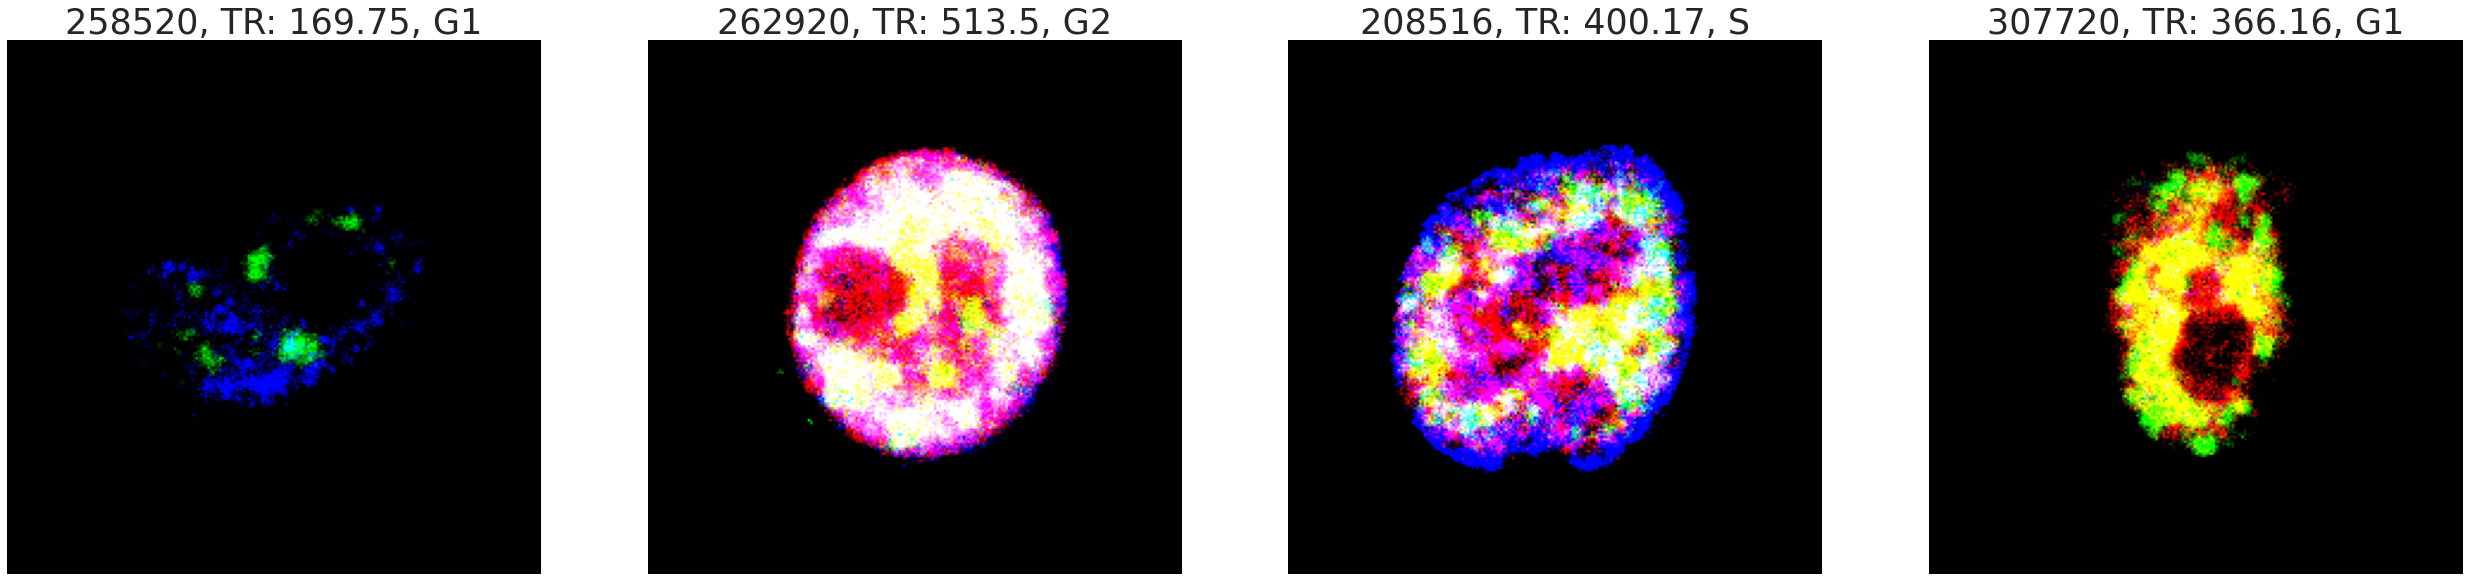

In [16]:
# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
n_cells = len(params['cells'])

plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data, test_data]
ds_names = ['train', 'val', 'test']
cell_count = 0
cells = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in params['cells']:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells[cell_id+'_img'] = cell['image'].numpy()
            cells[cell_id+'_img'] = cells[cell_id+'_img'][:,:,input_ids].astype(np.float32)
            
            cells[cell_id+'_mask'] = cell['image'].numpy()
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'][:,:,-1]
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'].astype(np.bool)
            
            # load score map
            temp_path = os.path.join(score_maps_dir, cell_id+'.npy')
            cells[cell_id+'_sm'] = np.load(temp_path)
            
            # just for curiosity
            temp_path = os.path.join(params['score_maps_path_lm_t4'], 'data', cell_id+'.npy')
            cells[cell_id+'_sm_lmt4'] = np.load(temp_path)
            temp_path = os.path.join(params['score_maps_path_lm_t7'], 'data', cell_id+'.npy')
            cells[cell_id+'_sm_lmt7'] = np.load(temp_path)
            
            # Plot cells
            temp_img = cells[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            # Get TR
            TR = cell['target'].numpy()[0]
            # get cc
            mask = metadata_df.mapobject_id_cell == cell_id
            cc = metadata_df[mask].cell_cycle.values[0]
            print(metadata_df[mask].set.values)

            nn_inter.plot_cell(img=temp_img, title=cell_id+', TR: '+str(round(TR, 2))+', '+cc, title_fontsize=35)

## 2.3 Load coefficients form linear models

In [18]:
importance_cols = ['channel_name', 'channel_percent', 'model', 'desc']
lm_importance_df = pd.DataFrame(columns=importance_cols)

for key in params['lin_model_dirs'].keys():
    temp_path = params['lin_model_dirs'][key][0]
    temp_path = os.path.join(temp_path, 'model', params['CMA'])
    temp_lm = tf.keras.models.load_model(temp_path)
    print(params['lin_model_dirs'][key][1], temp_lm.get_weights()[1])
    
    temp_df = pd.DataFrame(input_channel_names, columns=['channel_name'])
    temp_df['coef'] = temp_lm.get_weights()[0]
    total = temp_df.coef.abs().sum()
    temp_df['channel_percent'] = temp_df.coef.abs() / total
    temp_df['model'] = key
    temp_df['desc'] = params['lin_model_dirs'][key][1]
    
    
    lm_importance_df = pd.concat((lm_importance_df, temp_df[importance_cols]))

lm_importance_df

Coef_LM_Structure [370.26337]


Coef_LM_Color [355.9212]


channel_name  channel_percent          model               desc
0         00_DAPI         0.013796  LM_RIV2_test7  Coef_LM_Structure
1          07_H2B         0.029097  LM_RIV2_test7  Coef_LM_Structure
2   01_CDK9_pT186         0.058375  LM_RIV2_test7  Coef_LM_Structure
3         03_CDK9         0.048433  LM_RIV2_test7  Coef_LM_Structure
4        05_GTF2B         0.052608  LM_RIV2_test7  Coef_LM_Structure
..            ...              ...            ...                ...
28  13_POL2RA_pS5         0.012236  LM_RIV2_test4      Coef_LM_Color
29    15_U2SNRNPB         0.026077  LM_RIV2_test4      Coef_LM_Color
30        18_NONO         0.006883  LM_RIV2_test4      Coef_LM_Color
31      20_ALYREF         0.005234  LM_RIV2_test4      Coef_LM_Color
32        21_COIL         0.035559  LM_RIV2_test4      Coef_LM_Color

[66 rows x 4 columns]

## 2.4 Add y_hat of each model to targets_df 

In [21]:
#models_path = os.path.join(params['base_path'], 'Models', params['model_dir'])
targets_df = pd.DataFrame()
for i, model in enumerate(params['model_dirs'].keys()):
    model_dir = params['model_dirs'][model][0]
    print('Reading predicted values for model: ', model)
    temp_path = os.path.join(model_dir, 'targets_'+params['CMA']+'.csv')
    with open(temp_path, 'r') as file:
        temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(['y - y_hat'], axis=1)
    prediction_name = 'y_hat'+'_'+model
    temp_df[prediction_name] = temp_df.y_hat
    temp_df = temp_df.drop(['y_hat'], axis=1)
    if i == 0:
        targets_df = temp_df.copy()
    else:
        temp_df = temp_df[['mapobject_id_cell', prediction_name]]
        targets_df = targets_df.merge(temp_df, 
                                      left_on='mapobject_id_cell',
                                      right_on='mapobject_id_cell',
                                      how='left')
targets_df.mapobject_id_cell = targets_df.mapobject_id_cell.astype('string')
targets_df

Reading predicted values for model:  BL_RIV2_test4
Reading predicted values for model:  BL_RIV2_test8
Reading predicted values for model:  LM_RIV2_test7
Reading predicted values for model:  LM_RIV2_test4


y mapobject_id_cell    set perturbation cell_cycle  \
0     337.603180            305670  train         DMSO         G1   
1     436.179108            248989  train         DMSO         G1   
2     344.612427            212764  train       normal         G1   
3     397.731262            383254  train       normal         G1   
4     251.880371            287059  train         DMSO         G1   
...          ...               ...    ...          ...        ...   
3698  400.196350            321028   test       normal         G1   
3699  414.214355            194787   test       normal          S   
3700  354.966553            259718   test       normal         G1   
3701  425.607788            351947   test       normal         G1   
3702  452.497894            224150   test       normal         G1   

      y_hat_BL_RIV2_test4  y_hat_BL_RIV2_test8  y_hat_LM_RIV2_test7  \
0              393.687317           377.942047           386.438263   
1              432.883423           418.103790           393.045471   
2              340.201813           338.212463           366.720215   
3              351.875275           346.052582           354.480927   
4              375.951721           334.326904           382.703033   
...                   ...                  ...                  ...   
3698           418.039886           369.626709           385.436035   
3699           404.132172           392.717743           381.674438   
3700           350.943604           354.812927           365.009399   
3701           344.580719           366.152069           366.539276   
3702           471.355652           426.692413           392.160858   

      y_hat_LM_RIV2_test4  
0              383.838074  
1              388.925598  
2              343.983337  
3              326.733917  
4              362.086853  
...                   ...  
3698           359.554962  
3699           396.824036  
3700           351.926086  
3701           394.578979  
3702           397.396790  

[3703 rows x 9 columns]

## 2.5 Divide cells by low, medium and high TR

In [22]:
# Devide cell in Low TR medium and High
#low_per = targets_df.y.quantile(0.2)
#high_per = targets_df.y.quantile(0.8)
#print(low_per, high_per)
y_std = targets_df.y.std()
y_mean = targets_df.y.mean()
print(y_mean, y_std)
low_per = y_mean-y_std
high_per = y_mean+y_std
print(low_per, high_per)

mask_low = targets_df.y <= low_per
n_low = np.sum((mask_low).values)
mask_avg = (targets_df.y > low_per) & (targets_df.y < high_per)
n_avg = np.sum((mask_avg).values)
mask_high = targets_df.y >= high_per
n_high = np.sum((mask_high).values)
print(n_low, n_avg, n_high)
n_samples = n_low + n_avg + n_high
print(n_low/n_samples, n_avg/n_samples, n_high/n_samples)

# Save TR level
targets_df['TR_Level'] = 'Medium_TR'
temp_idxs = targets_df[mask_low].index
targets_df.loc[temp_idxs, 'TR_Level'] = 'Low_TR'
temp_idxs = targets_df[mask_high].index
targets_df.loc[temp_idxs, 'TR_Level'] = 'High_TR'
targets_df

377.2833369803886 60.71855957335795
316.56477740703065 438.0018965537465
532 2626 545
0.14366729678638943 0.7091547394004861 0.1471779638131245


y mapobject_id_cell    set perturbation cell_cycle  \
0     337.603180            305670  train         DMSO         G1   
1     436.179108            248989  train         DMSO         G1   
2     344.612427            212764  train       normal         G1   
3     397.731262            383254  train       normal         G1   
4     251.880371            287059  train         DMSO         G1   
...          ...               ...    ...          ...        ...   
3698  400.196350            321028   test       normal         G1   
3699  414.214355            194787   test       normal          S   
3700  354.966553            259718   test       normal         G1   
3701  425.607788            351947   test       normal         G1   
3702  452.497894            224150   test       normal         G1   

      y_hat_BL_RIV2_test4  y_hat_BL_RIV2_test8  y_hat_LM_RIV2_test7  \
0              393.687317           377.942047           386.438263   
1              432.883423           418.103790           393.045471   
2              340.201813           338.212463           366.720215   
3              351.875275           346.052582           354.480927   
4              375.951721           334.326904           382.703033   
...                   ...                  ...                  ...   
3698           418.039886           369.626709           385.436035   
3699           404.132172           392.717743           381.674438   
3700           350.943604           354.812927           365.009399   
3701           344.580719           366.152069           366.539276   
3702           471.355652           426.692413           392.160858   

      y_hat_LM_RIV2_test4   TR_Level  
0              383.838074  Medium_TR  
1              388.925598  Medium_TR  
2              343.983337  Medium_TR  
3              326.733917  Medium_TR  
4              362.086853     Low_TR  
...                   ...        ...  
3698           359.554962  Medium_TR  
3699           396.824036  Medium_TR  
3700           351.926086  Medium_TR  
3701           394.578979  Medium_TR  
3702           397.396790    High_TR  

[3703 rows x 10 columns]

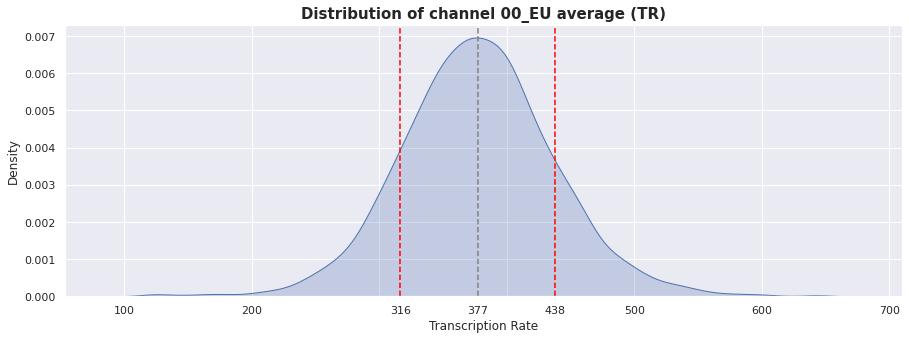

In [23]:
data = targets_df.y.values

fig = plt.figure(figsize=(15,5))
#sns.violinplot(y=data, orient='v')
sns.kdeplot(data, shade=True)
plt.axvline(low_per, 0, 1, ls='--', c='red')
plt.axvline(high_per, 0, 1, ls='--', c='red')
plt.axvline(y_mean, 0, 1, ls='--', c='grey')
#plt.text(0.5, 0.0005, 'matplotlib', horizontalalignment='center',
#         verticalalignment='center')
plt.xticks(ticks=[100, 200, 300, 400, 500, 600, 700, low_per, y_mean, high_per],
           labels=[100, 200, "", "", 500, 600, 700, int(low_per), int(y_mean), int(high_per)])
_ = plt.xlabel('Transcription Rate')
_ = plt.title('Distribution of channel 00_EU average (TR)', fontsize=15, fontweight='bold')
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)

In [24]:
score_map_stddev = pd.DataFrame()
for model in params['model_dirs']:
    model_dir = params['model_dirs'][model][0]
    temp_df = pd.read_csv(os.path.join(model_dir, 'score_map_stddev.csv'))
    score_map_stddev = pd.concat((score_map_stddev, temp_df), ignore_index=True)
score_map_stddev.mapobject_id_cell = score_map_stddev.mapobject_id_cell.astype('string')

    
# Add more info
score_map_stddev = score_map_stddev.merge(targets_df,
                                          left_on='mapobject_id_cell',
                                          right_on='mapobject_id_cell',
                                          how='left')
score_map_stddev

00_DAPI    07_H2B  01_CDK9_pT186   03_CDK9  05_GTF2B  07_SETD1A  \
0      0.021754  0.026529       0.034256  0.023857  0.046141   0.049208   
1      0.020187  0.035958       0.050179  0.034767  0.049775   0.042416   
2      0.018894  0.026342       0.027377  0.024820  0.054287   0.034398   
3      0.018316  0.023719       0.025623  0.026080  0.054002   0.034795   
4      0.023178  0.033219       0.032957  0.025359  0.039486   0.038332   
...         ...       ...            ...       ...       ...        ...   
14807  0.008843  0.013764       0.059365  0.000935  0.076503   0.038702   
14808  0.008845  0.013733       0.059291  0.000934  0.076371   0.038675   
14809  0.008832  0.013770       0.059307  0.000936  0.076276   0.038724   
14810  0.008841  0.013744       0.059379  0.000935  0.076355   0.038671   
14811  0.008840  0.013755       0.059314  0.000933  0.076387   0.038705   

       08_H3K4me3  09_SRRM2  10_H3K27ac  11_KPNA2_MAX  12_RB1_pS807_S811  \
0        0.030868  0.047396    0.017080      0.019650           0.020092   
1        0.032182  0.038114    0.016155      0.022010           0.017576   
2        0.025356  0.042189    0.019616      0.022974           0.015177   
3        0.026364  0.044107    0.020712      0.020142           0.016356   
4        0.028650  0.042185    0.023298      0.032004           0.016112   
...           ...       ...         ...           ...                ...   
14807    0.062534  0.003246    0.029715      0.016864           0.008857   
14808    0.062558  0.003243    0.029653      0.016878           0.008875   
14809    0.062555  0.003239    0.029656      0.016853           0.008878   
14810    0.062464  0.003246    0.029671      0.016849           0.008865   
14811    0.062597  0.003252    0.029684      0.016900           0.008889   

       13_PABPN1   14_PCNA    15_SON     16_H3  17_HDAC3  19_KPNA1_MAX  \
0       0.039375  0.030082  0.029414  0.024536  0.038465      0.014033   
1       0.034342  0.017154  0.016386  0.025218  0.043587      0.023486   
2       0.037974  0.024109  0.030445  0.036172  0.028468      0.016492   
3       0.035735  0.024801  0.029357  0.028014  0.025221      0.016634   
4       0.039168  0.024097  0.020038  0.034207  0.048472      0.023686   
...          ...       ...       ...       ...       ...           ...   
14807   0.017483  0.028732  0.011962  0.055130  0.010288      0.021438   
14808   0.017499  0.028713  0.011965  0.055047  0.010285      0.021470   
14809   0.017443  0.028742  0.011946  0.055033  0.010306      0.021429   
14810   0.017457  0.028756  0.011982  0.055148  0.010296      0.021487   
14811   0.017494  0.028716  0.011932  0.055158  0.010299      0.021471   

       20_SP100    21_NCL  01_PABPC1   02_CDK7   03_RPS6     05_Sm  07_POLR2A  \
0      0.022731  0.034001   0.013857  0.023052  0.032130  0.029906   0.032766   
1      0.017619  0.038527   0.018933  0.023193  0.043794  0.034108   0.026417   
2      0.018544  0.058972   0.020592  0.017053  0.038208  0.036632   0.022429   
3      0.018969  0.057283   0.025418  0.016562  0.036844  0.042424   0.021965   
4      0.019167  0.030599   0.022228  0.022879  0.047623  0.027645   0.026608   
...         ...       ...        ...       ...       ...       ...        ...   
14807  0.012486  0.057741   0.016210  0.016219  0.030319  0.060031   0.033839   
14808  0.012471  0.057830   0.016238  0.016197  0.030296  0.060123   0.033835   
14809  0.012468  0.057838   0.016232  0.016224  0.030306  0.060088   0.033847   
14810  0.012470  0.057750   0.016246  0.016179  0.030354  0.060076   0.033833   
14811  0.012458  0.057743   0.016251  0.016178  0.030287  0.060055   0.033847   

       09_CCNT1  10_POL2RA_pS2    11_PML   12_YAP1  13_POL2RA_pS5  \
0      0.024469       0.082783  0.020691  0.018230       0.030914   
1      0.022609       0.072789  0.015469  0.021051       0.032337   
2      0.025903       0.074867  0.023934  0.013758       0.033574   
3      0.029334       0.073191  0.027087  0.016241      

In [25]:
channel_columns = list(channels_df.set_index('TFDS_channel_id').iloc[input_ids].name.values)
index_columns = ['mapobject_id_cell', 'Model', 'set', 'cell_cycle', 'TR_Level']
stack_score_df = score_map_stddev[index_columns + channel_columns].set_index(index_columns).stack().reset_index().copy()
stack_score_df.columns = index_columns + ['channel_name', 'channel_stddev']
stack_score_df

mapobject_id_cell          Model    set cell_cycle   TR_Level  \
0                 305670  BL_RIV2_test4  train         G1  Medium_TR   
1                 305670  BL_RIV2_test4  train         G1  Medium_TR   
2                 305670  BL_RIV2_test4  train         G1  Medium_TR   
3                 305670  BL_RIV2_test4  train         G1  Medium_TR   
4                 305670  BL_RIV2_test4  train         G1  Medium_TR   
...                  ...            ...    ...        ...        ...   
488791            224150  LM_RIV2_test4   test         G1    High_TR   
488792            224150  LM_RIV2_test4   test         G1    High_TR   
488793            224150  LM_RIV2_test4   test         G1    High_TR   
488794            224150  LM_RIV2_test4   test         G1    High_TR   
488795            224150  LM_RIV2_test4   test         G1    High_TR   

         channel_name  channel_stddev  
0             00_DAPI        0.021754  
1              07_H2B        0.026529  
2       01_CDK9_pT186        0.034256  
3             03_CDK9        0.023857  
4            05_GTF2B        0.046141  
...               ...             ...  
488791  13_POL2RA_pS5        0.012232  
488792    15_U2SNRNPB        0.026064  
488793        18_NONO        0.006890  
488794      20_ALYREF        0.005241  
488795        21_COIL        0.035570  

[488796 rows x 7 columns]

# 3 Channel importance analisis

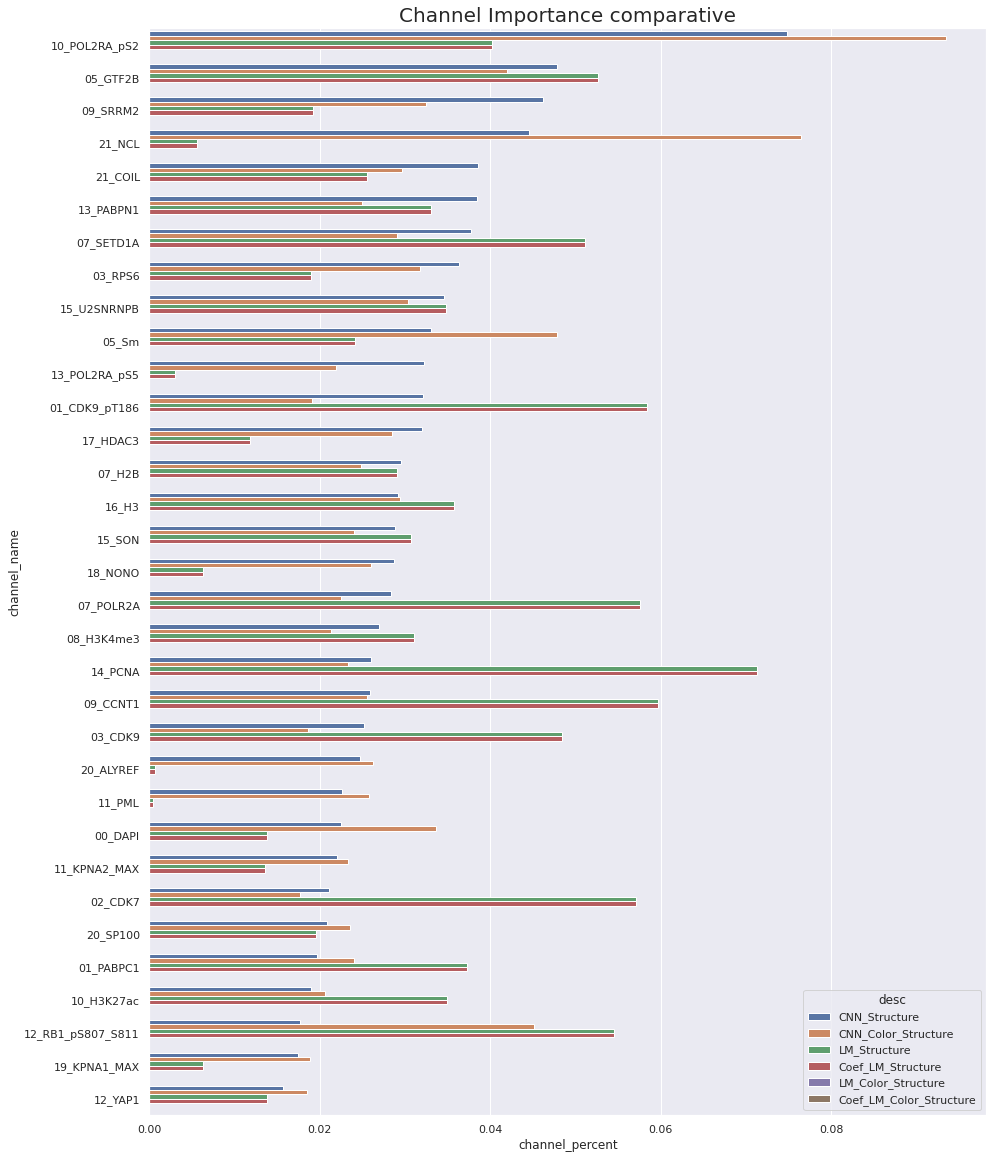

In [27]:
importance_cols = ['channel_name', 'channel_percent', 'model', 'desc']
importance_df = pd.DataFrame(columns=importance_cols)

for model in params['model_dirs'].keys():
    
    mask = stack_score_df.Model == model
    temp_df = stack_score_df[mask].copy()
    #temp_df = stack_score_df.copy()
    temp_df = temp_df.groupby(['channel_name']).mean().reset_index()
    total = temp_df.channel_stddev.sum()
    temp_df['channel_percent'] = temp_df['channel_stddev'] / total
    temp_df = temp_df.sort_values(by=['channel_percent'], ascending=False)
    temp_df['model'] = model
    temp_df['desc'] = params['model_dirs'][model][1]
    
    #print(temp_df.channel_name.values)
    importance_df = pd.concat((importance_df, temp_df[importance_cols]))
    
temp_df = pd.concat((importance_df, lm_importance_df))
#temp_df = importance_df

hue_order = ['CNN_Structure', 'CNN_Color_Structure', 'LM_Structure', 'Coef_LM_Structure', 'LM_Color_Structure', 'Coef_LM_Color_Structure']

plt.figure(figsize=(15,20))
sns.barplot(data=temp_df,
            x="channel_percent",
            y="channel_name",
            #hue_order=order,
            orient="h",
            hue='desc',
            hue_order=hue_order
            #palette="viridis",
            )
_ = plt.title('Channel Importance comparative', fontsize=20)
    #plt.savefig('./temp_'+model+'.png')

The take away for the plot above is that the cumulative per-channel variance of the linear models is almos the same as the coefficients!

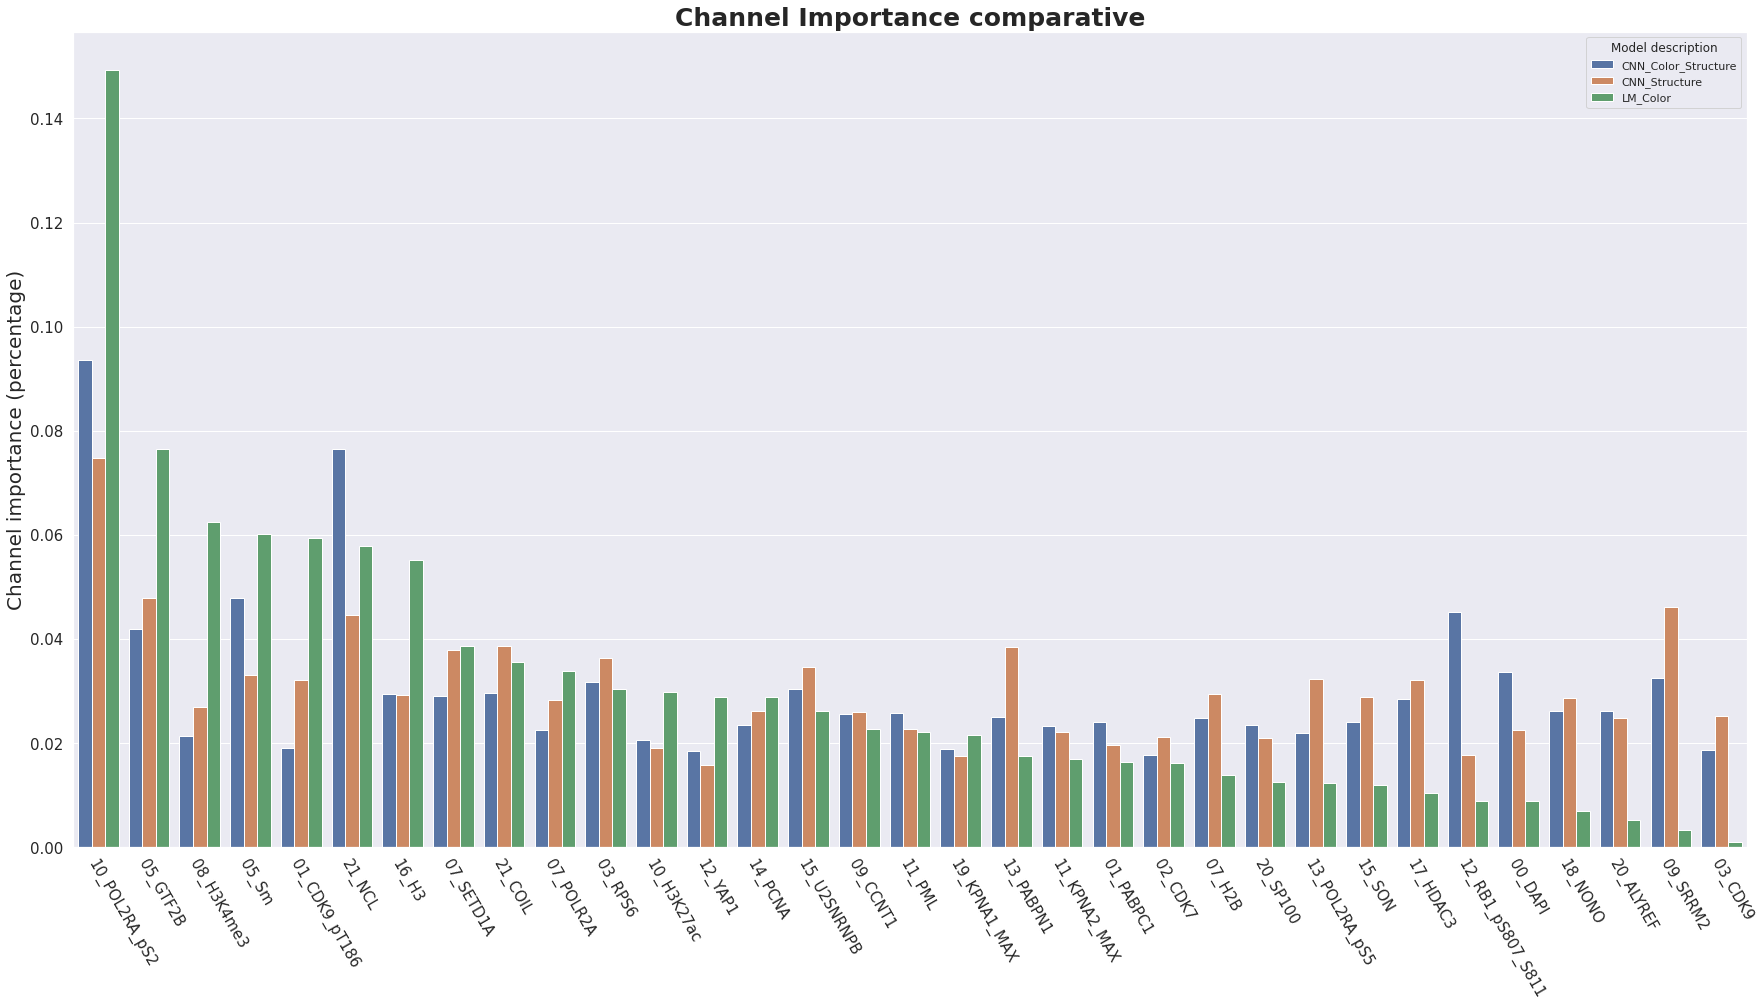

In [28]:
importance_cols = ['channel_name', 'channel_percent', 'model', 'desc']
importance_df = pd.DataFrame(columns=importance_cols)

#models_to_plot = ['BL_RIV2_test4', 'BL_RIV2_test8', 'LM_RIV2_test7', 'LM_RIV2_test4']
models_to_plot = ['BL_RIV2_test4', 'BL_RIV2_test8', 'LM_RIV2_test4']
for model in models_to_plot:
    
    mask = stack_score_df.Model == model
    temp_df = stack_score_df[mask].copy()
    #temp_df = stack_score_df.copy()
    temp_df = temp_df.groupby(['channel_name']).mean().reset_index()
    total = temp_df.channel_stddev.sum()
    temp_df['channel_percent'] = temp_df['channel_stddev'] / total
    temp_df = temp_df.sort_values(by=['channel_percent'], ascending=False)
    temp_df['model'] = model
    temp_df['desc'] = params['model_dirs'][model][1]
    
    #print(temp_df.channel_name.values)
    importance_df = pd.concat((importance_df, temp_df[importance_cols]))
    
temp_df = importance_df.sort_values(by=['model', 'channel_percent'], ascending=False)

#hue_order = ['CNN_Color_Structure', 'CNN_Structure', 'LM_Color_Structure', 'LM_Structure']
hue_order = ['CNN_Color_Structure', 'CNN_Structure', 'LM_Color']

fig = plt.figure(figsize=(30,15))
sns.barplot(data=temp_df,
            y="channel_percent",
            x="channel_name",
            #hue_order=order,
            orient="v",
            hue='desc',
            hue_order=hue_order
            #palette="viridis",
            )
plt.xticks(rotation=-60, rotation_mode='anchor', horizontalalignment='left', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Channel importance (percentage)', fontsize=20)
plt.xlabel('')
_ = plt.title('Channel Importance comparative', fontsize=25, fontweight='bold')
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)
_ = plt.legend(title='Model description', loc='upper right')

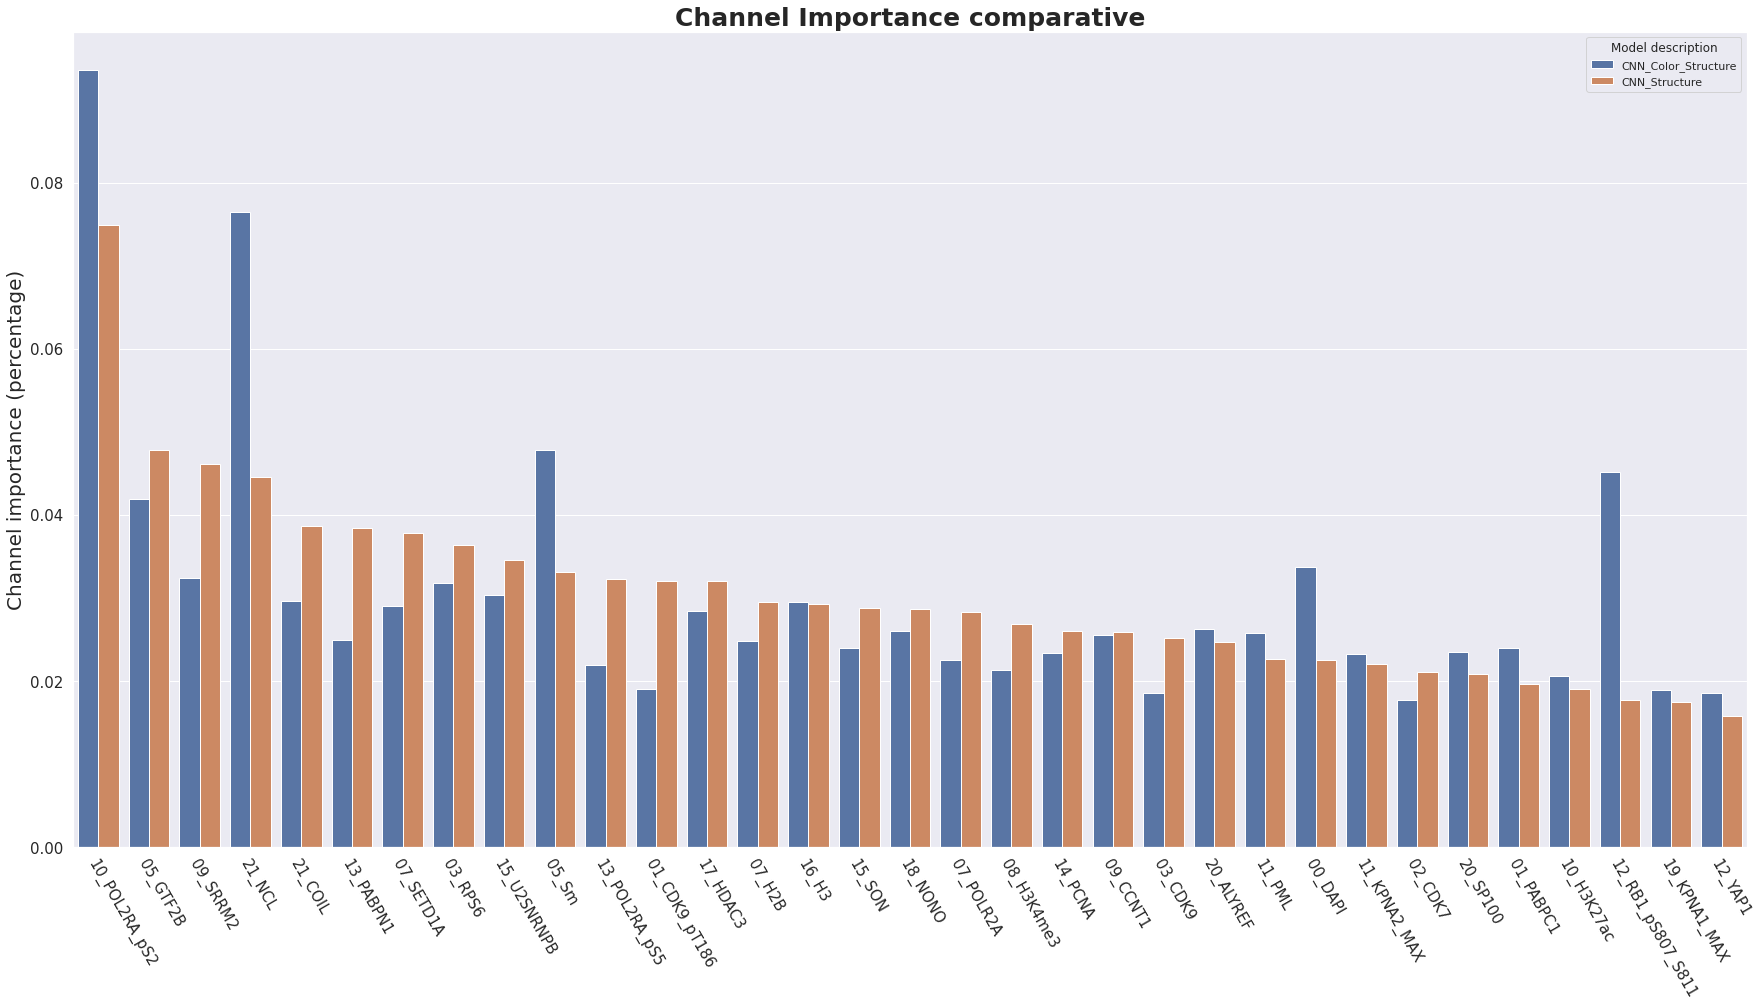

In [29]:
importance_cols = ['channel_name', 'channel_percent', 'model', 'desc']
importance_df = pd.DataFrame(columns=importance_cols)

#models_to_plot = ['BL_RIV2_test4', 'BL_RIV2_test8', 'LM_RIV2_test7', 'LM_RIV2_test4']
models_to_plot = ['BL_RIV2_test4', 'BL_RIV2_test8']
for model in models_to_plot:
    
    mask = stack_score_df.Model == model
    temp_df = stack_score_df[mask].copy()
    #temp_df = stack_score_df.copy()
    temp_df = temp_df.groupby(['channel_name']).mean().reset_index()
    total = temp_df.channel_stddev.sum()
    temp_df['channel_percent'] = temp_df['channel_stddev'] / total
    temp_df = temp_df.sort_values(by=['channel_percent'], ascending=False)
    temp_df['model'] = model
    temp_df['desc'] = params['model_dirs'][model][1]
    
    #print(temp_df.channel_name.values)
    importance_df = pd.concat((importance_df, temp_df[importance_cols]))
    
temp_df = importance_df.sort_values(by=['desc', 'channel_percent'], ascending=False)

#hue_order = ['CNN_Color_Structure', 'CNN_Structure', 'LM_Color_Structure', 'LM_Structure']
hue_order = ['CNN_Color_Structure', 'CNN_Structure']

fig = plt.figure(figsize=(30,15))
sns.barplot(data=temp_df,
            y="channel_percent",
            x="channel_name",
            #hue_order=order,
            orient="v",
            hue='desc',
            hue_order=hue_order
            #palette="viridis",
            )
plt.xticks(rotation=-60, rotation_mode='anchor', horizontalalignment='left', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Channel importance (percentage)', fontsize=20)
plt.xlabel('')
_ = plt.title('Channel Importance comparative', fontsize=25, fontweight='bold')
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)
_ = plt.legend(title='Model description', loc='upper right')

['10_POL2RA_pS2' '05_GTF2B' '09_SRRM2' '21_NCL' '21_COIL' '13_PABPN1'
 '07_SETD1A' '03_RPS6' '15_U2SNRNPB' '05_Sm']


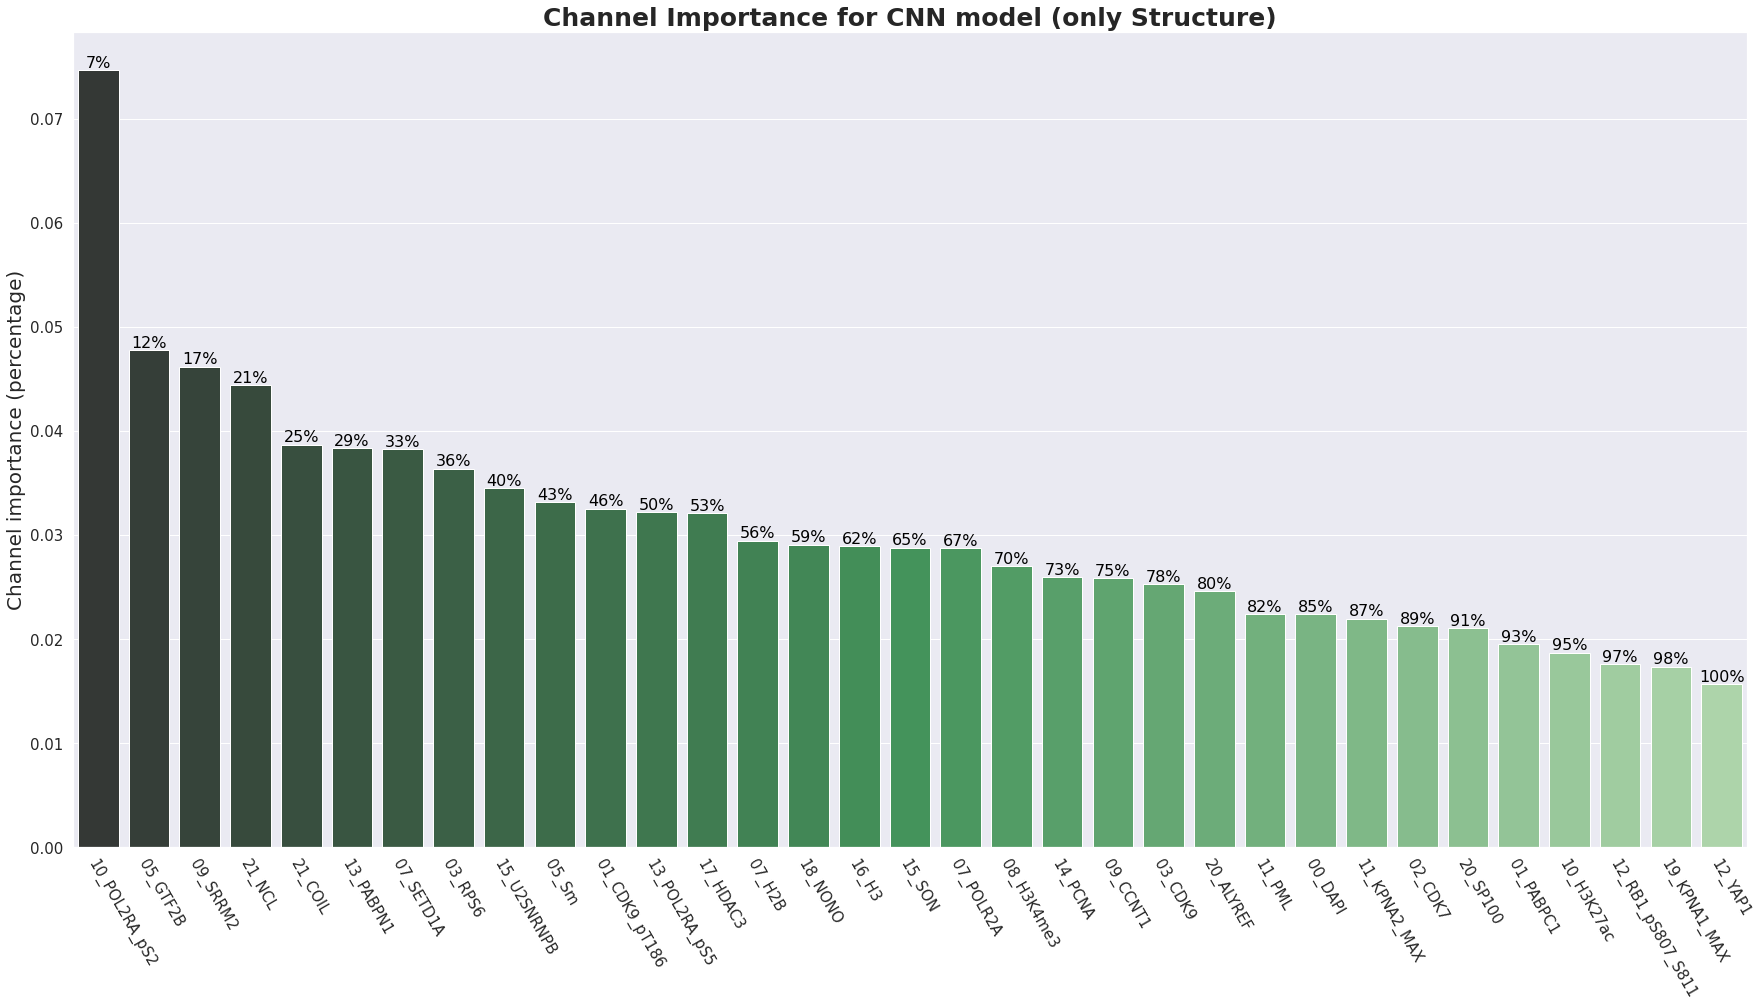

In [30]:
importance_cols = ['channel_name', 'channel_percent', 'model', 'desc']
importance_df = pd.DataFrame(columns=importance_cols)

mask = stack_score_df.Model == 'BL_RIV2_test4'
mask &= stack_score_df.set == 'test'
temp_df = stack_score_df[mask].copy()
temp_df = temp_df.groupby(['channel_name']).mean().reset_index()
total = temp_df.channel_stddev.sum()
temp_df['channel_percent'] = temp_df['channel_stddev'] / total
temp_df = temp_df.sort_values(by=['channel_percent'], ascending=False)
temp_df = temp_df.sort_values(by='channel_percent', ascending=False).reset_index()
temp_df['cum_percent'] = temp_df['channel_percent'].cumsum()

fig = plt.figure(figsize=(30,15))
pal = sns.color_palette("Greens_d", temp_df.shape[0])
g = sns.barplot(data=temp_df,
            y="channel_percent",
            x="channel_name",
            #hue_order=order,
            orient="v",
            palette=np.array(pal[::-1]),
            )

for _, row in temp_df.iterrows():
    g.text(row.name, row['channel_percent'], str(int(round(100 * row['cum_percent'],0)))+'%', color='black', ha="center", va="bottom", fontsize=16)

plt.xticks(rotation=-60, rotation_mode='anchor', horizontalalignment='left', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Channel importance (percentage)', fontsize=20)
plt.xlabel('')
_ = plt.title('Channel Importance for CNN model (only Structure)', fontsize=25, fontweight='bold')
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)
print(temp_df['channel_name'].head(10).values)

['10_POL2RA_pS2' '10_POL2RA_pS2' '10_POL2RA_pS2' '05_GTF2B' '05_GTF2B'
 '05_GTF2B' '09_SRRM2' '09_SRRM2' '09_SRRM2' '21_NCL']


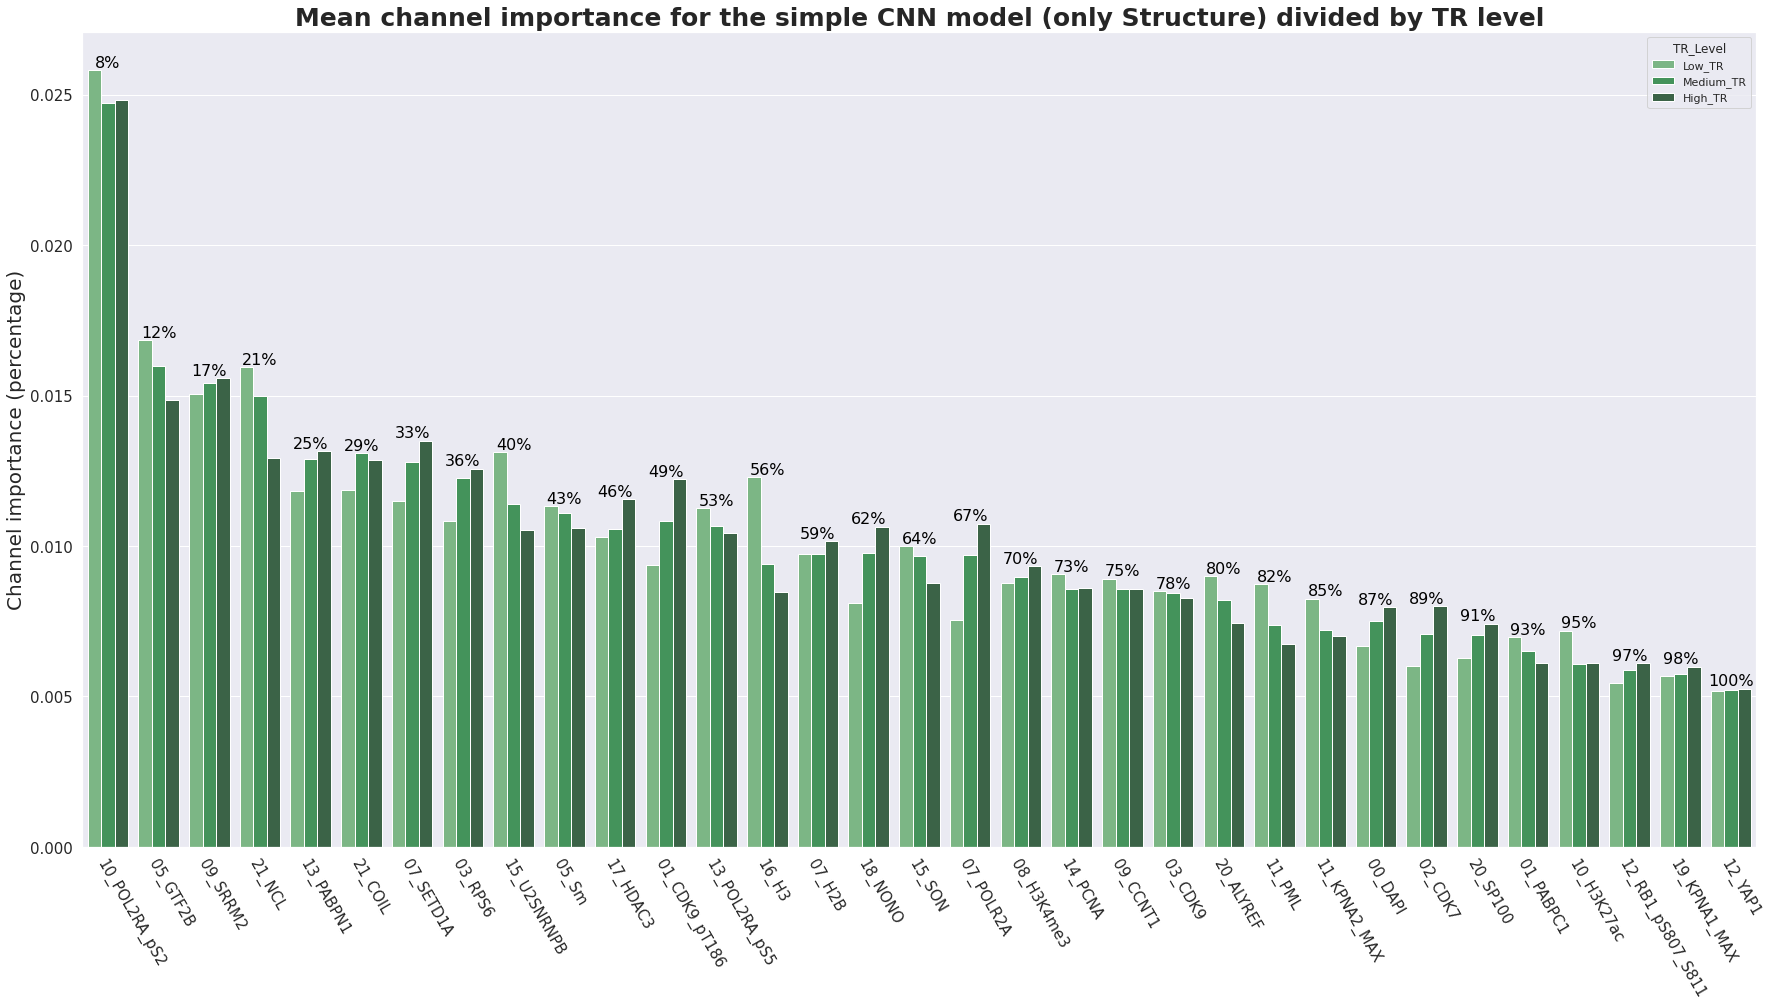

In [31]:
importance_cols = ['channel_name', 'channel_percent', 'model', 'desc', 'TR_Level']
importance_df = pd.DataFrame(columns=importance_cols)

mask = stack_score_df.Model == 'BL_RIV2_test4'
mask &= stack_score_df.set == 'test'
temp_df = stack_score_df[mask].copy()
temp_df = temp_df.groupby(['channel_name', 'TR_Level']).mean().reset_index()
total = temp_df.channel_stddev.sum()
temp_df['channel_percent'] = temp_df['channel_stddev'] / total

# get the total percentage per channel
total_channel_percent = temp_df[['channel_name', 'channel_percent']].groupby(['channel_name']).sum()
total_channel_percent = total_channel_percent.reset_index()
total_channel_percent = total_channel_percent.sort_values(by='channel_percent', ascending=False).reset_index()
total_channel_percent = total_channel_percent.drop(['index'], axis=1)
total_channel_percent.columns = ['channel_name', 'total_channel_percent']
temp_df = temp_df.merge(total_channel_percent, 
                        left_on='channel_name', 
                        right_on='channel_name',
                        how='left')
temp_df = temp_df.sort_values(by='total_channel_percent', ascending=False)

fig = plt.figure(figsize=(30,15))
pal = sns.color_palette("Greens_d", 3)
g = sns.barplot(data=temp_df,
            y="channel_percent",
            x="channel_name",
            hue='TR_Level',
            hue_order=['Low_TR', 'Medium_TR', 'High_TR'],
            orient="v",
            palette=np.array(pal),
            )

###########
# Add labels at the top of each bar
###########
temp2_df = temp_df[['channel_name', 'channel_percent']].groupby(['channel_name']).max().reset_index()
temp2_df.columns = ['channel_name', 'bar_hight']
total_channel_percent = total_channel_percent.merge(temp2_df, left_on='channel_name', 
                        right_on='channel_name',
                        how='left')
total_channel_percent['cum_percent'] = total_channel_percent['total_channel_percent'].cumsum()
for _, row in total_channel_percent.iterrows():
    g.text(row.name, row['bar_hight'], str(int(round(100 * row['cum_percent'],0)))+'%', color='black', ha="center", va="bottom", fontsize=16)


plt.xticks(rotation=-60, rotation_mode='anchor', horizontalalignment='left', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Channel importance (percentage)', fontsize=20)
plt.xlabel('')
_ = plt.title('Mean channel importance for the simple CNN model (only Structure) divided by TR level', fontsize=25, fontweight='bold')
fig.savefig('./temp.jpg', bbox_inches='tight', pad_inches=0)
print(temp_df['channel_name'].head(10).values)

['10_POL2RA_pS2' '10_POL2RA_pS2' '10_POL2RA_pS2' '10_POL2RA_pS2'
 '10_POL2RA_pS2' '10_POL2RA_pS2' '10_POL2RA_pS2' '10_POL2RA_pS2'
 '10_POL2RA_pS2' '10_POL2RA_pS2']


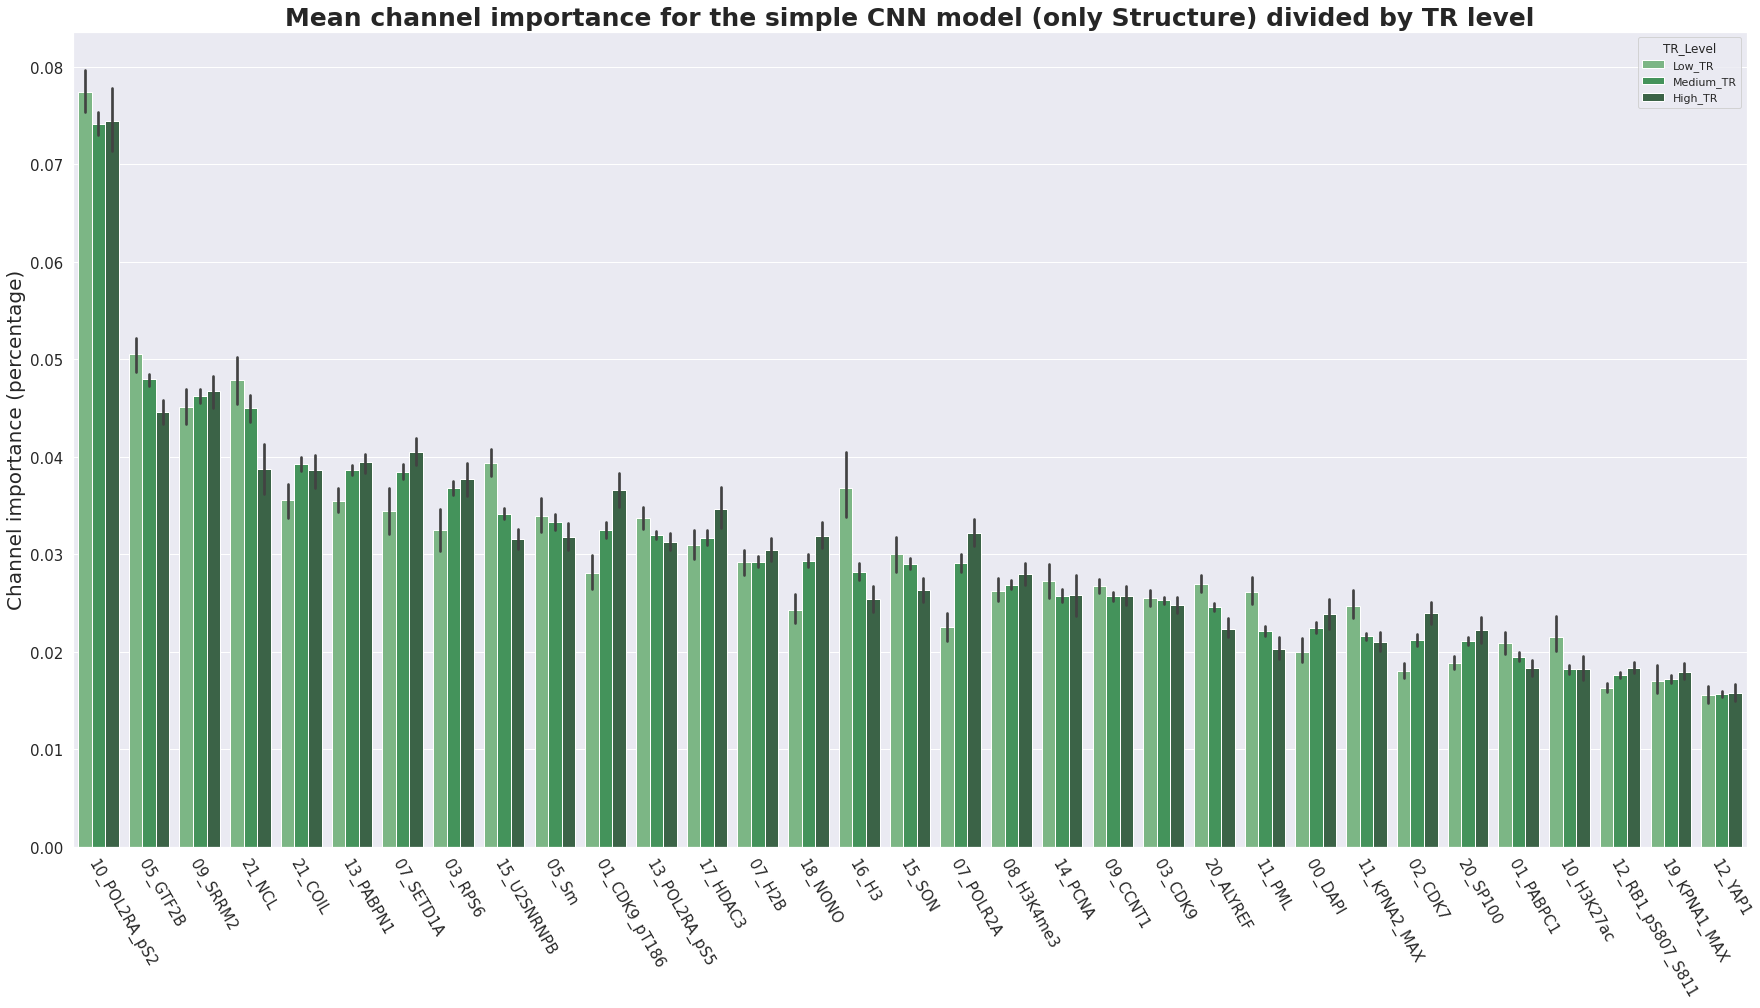

In [32]:
mask = stack_score_df.Model == 'BL_RIV2_test4'
mask &= stack_score_df.set == 'test'
temp_df = stack_score_df[mask].copy()
#temp_df = stack_score_df.copy()


temp2_df = temp_df.groupby('channel_name').mean().reset_index()
temp2_df.columns = ['channel_name', 'channel_mean_stddev']
temp_df = temp_df.merge(temp2_df, 
                        left_on='channel_name', 
                        right_on='channel_name',
                        how='left')
temp_df = temp_df.sort_values(by='channel_mean_stddev', ascending=False).reset_index().drop('index', axis=1)

fig = plt.figure(figsize=(30,15))
pal = sns.color_palette("Greens_d", 3)
g = sns.barplot(data=temp_df,
            y="channel_stddev",
            x="channel_name",
            hue='TR_Level',
            hue_order=['Low_TR', 'Medium_TR', 'High_TR'],
            orient="v",
            ci=99,
            palette=np.array(pal),
            )

plt.xticks(rotation=-60, rotation_mode='anchor', horizontalalignment='left', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Channel importance (percentage)', fontsize=20)
plt.xlabel('')
_ = plt.title('Mean channel importance for the simple CNN model (only Structure) divided by TR level', fontsize=25, fontweight='bold')
fig.savefig('./Channel_importance.JPG', bbox_inches='tight', pad_inches=0)
print(temp_df['channel_name'].head(10).values)

# 4 Score maps visualization

In [33]:
def move_img_into_0_1(temp_img, temp_mask):
    min_vals = temp_img[temp_mask].min(axis=0)
    max_vals = temp_img[temp_mask].max(axis=0)
    
    temp_img[temp_mask] = (temp_img[temp_mask] - min_vals) / (max_vals - min_vals)
    
    return temp_img

## 4.1 Baseline model (used for the final thesis)

[25  4  7 18 32 11  5 21 29 22]


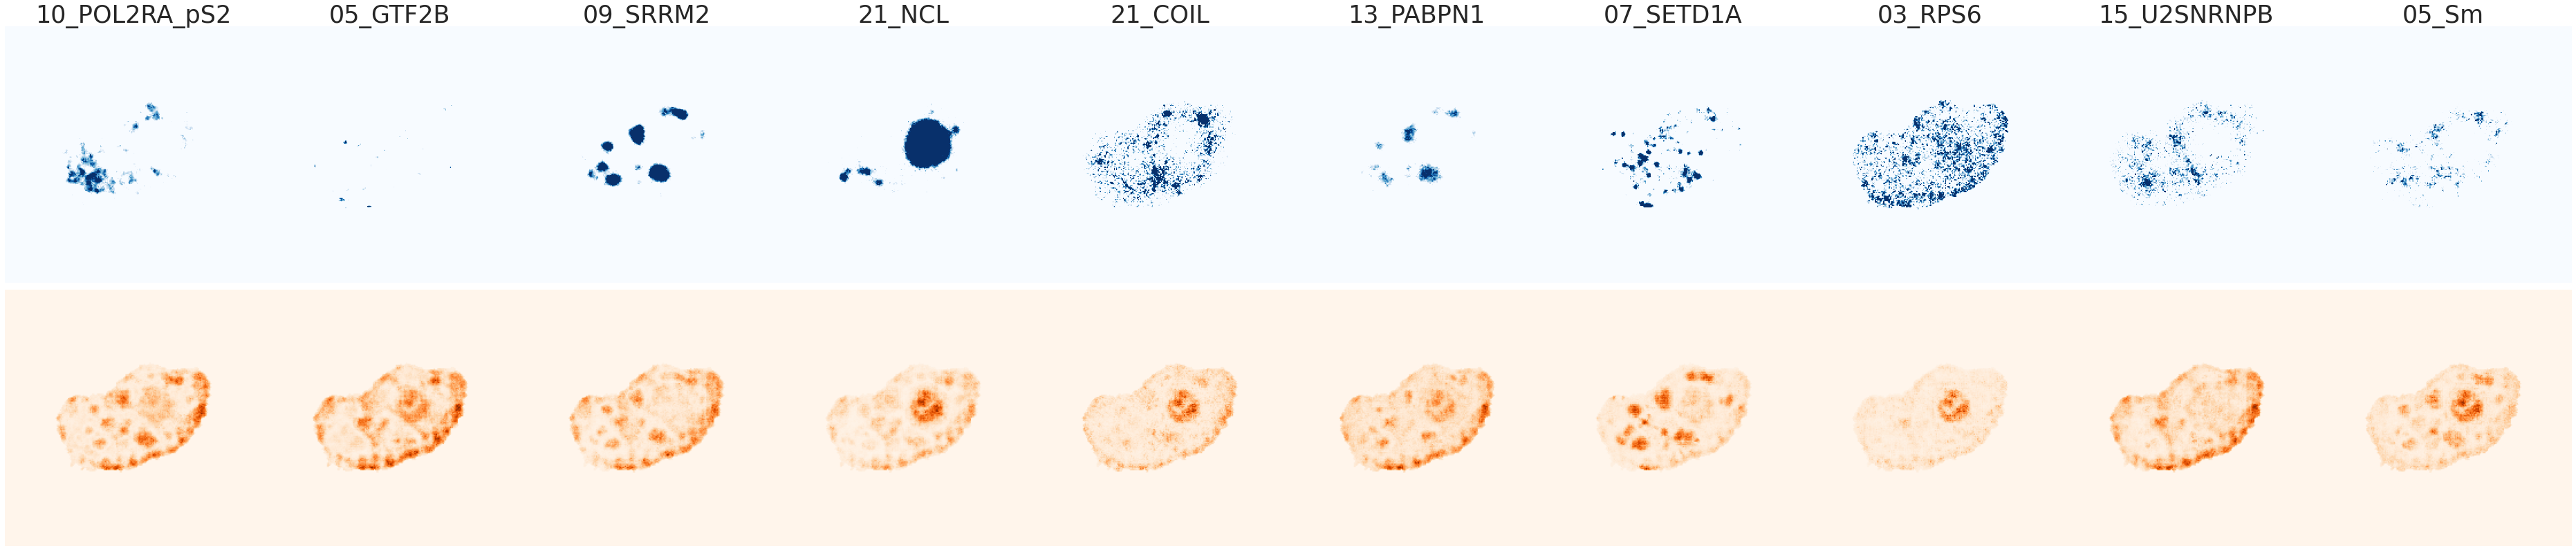

In [37]:
names_channels_2_plot = ['10_POL2RA_pS2', '05_GTF2B', '09_SRRM2', '21_NCL', '21_COIL', '13_PABPN1', '07_SETD1A', '03_RPS6', '15_U2SNRNPB', '05_Sm']
channels_2_plot = channels_df.set_index('name').loc[names_channels_2_plot].TFDS_channel_id.astype(np.int16).values
print(channels_2_plot)

cell_id = '258520'
score_map = copy.deepcopy(cells[cell_id+'_sm'])
cell_img = copy.deepcopy(cells[cell_id+'_img'])
cell_mask = cells[cell_id+'_mask']
    
# Original img and score map
nn_inter.plot_VarGrad_IG_2(img=cell_img,
                           img_mask=cell_mask,
                           score_maps={'BL_RIV2_test4': score_map},
                           top_percent=1,
                           channels_df=channels_df,
                           img_size=(7,7),
                           score_map_same_sacale=False,
                           channels_2_plot=channels_2_plot,
                           plot_overlap=False,
                           plot_colorbar=False,
                           plot_name='./temp.jpg'#'./Plots/BL_VarGrad_'+cell+'_0_5.png'
                            )

## 4.1 Linear model (only for testing)

[25  4  7 18 32 11  5 21 29 22]


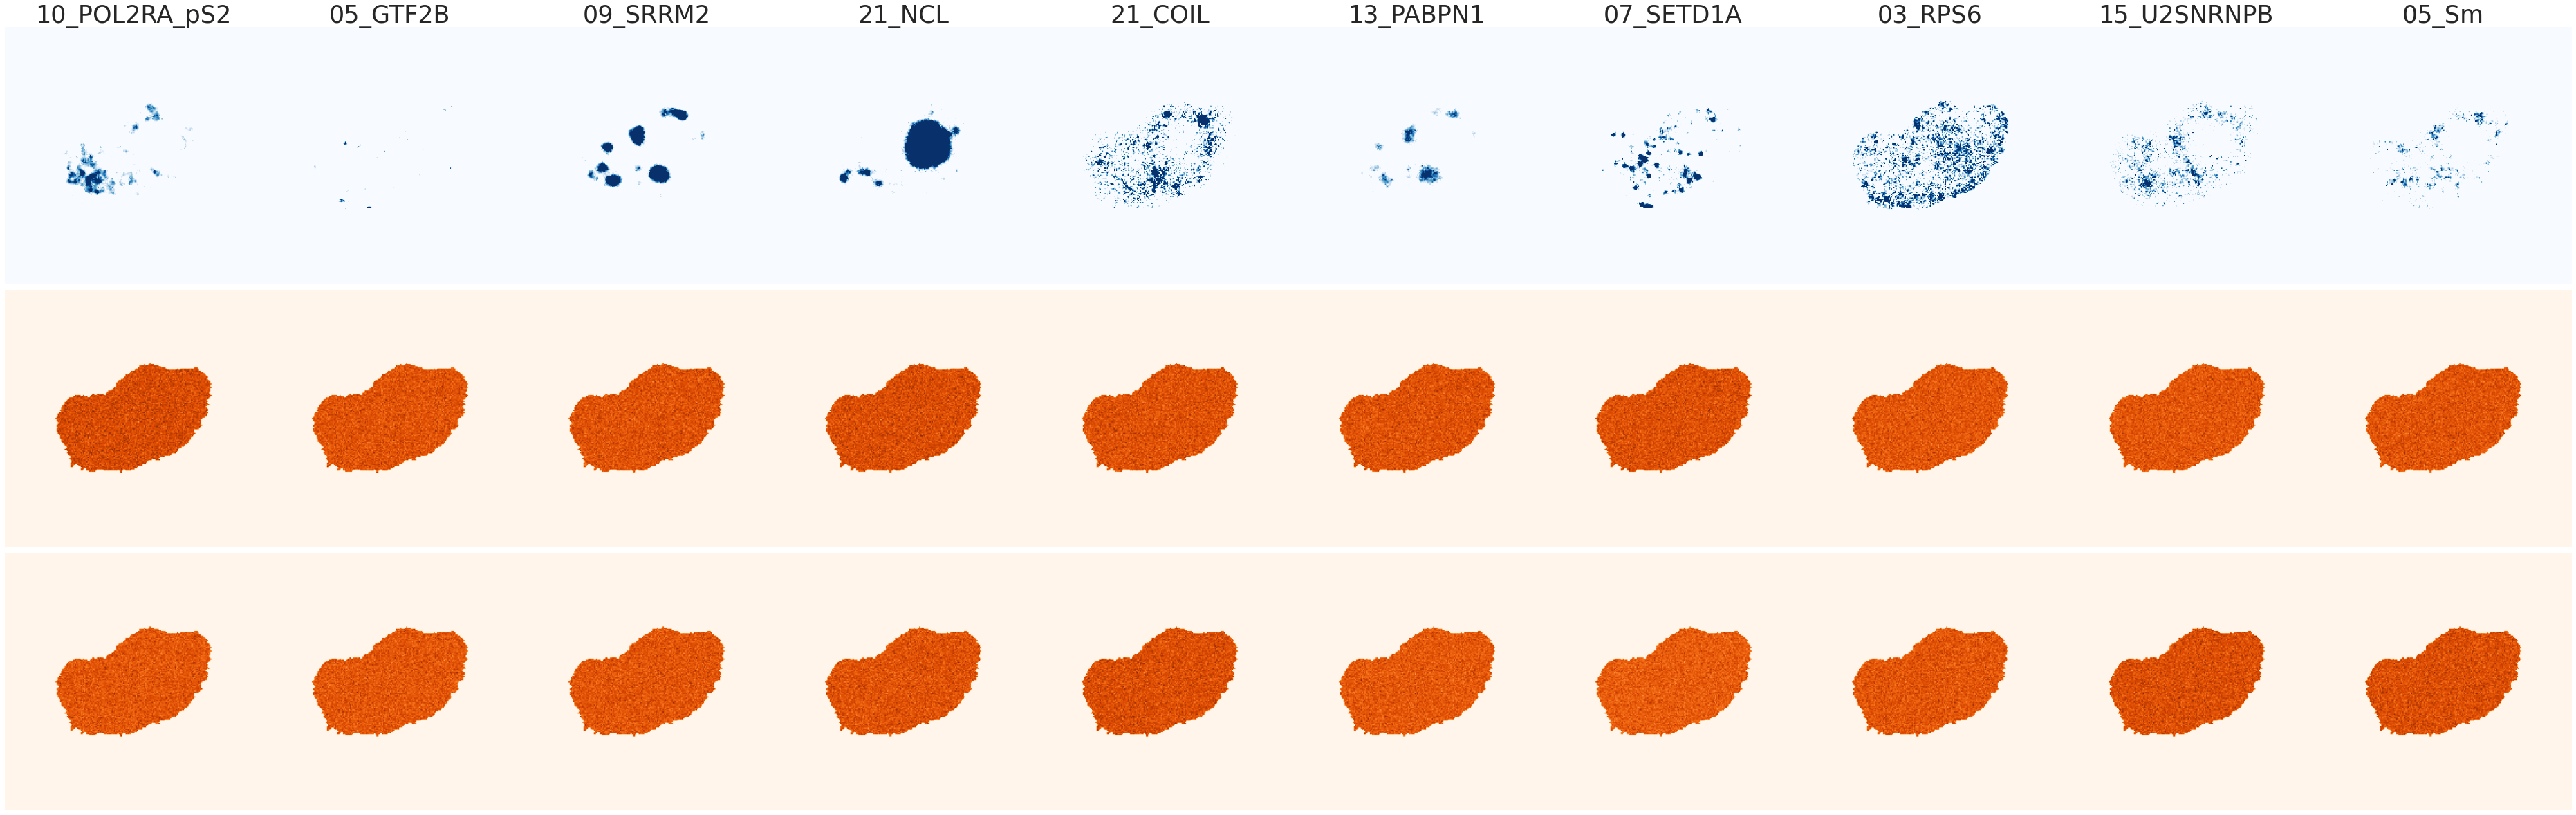

In [39]:
names_channels_2_plot = ['10_POL2RA_pS2', '05_GTF2B', '09_SRRM2', '21_NCL', '21_COIL', '13_PABPN1', '07_SETD1A', '03_RPS6', '15_U2SNRNPB', '05_Sm']
channels_2_plot = channels_df.set_index('name').loc[names_channels_2_plot].TFDS_channel_id.astype(np.int16).values
print(channels_2_plot)

cell_id = '258520'
score_map_sm_lmt4 = copy.deepcopy(cells[cell_id+'_sm_lmt4'])
score_map_sm_lmt7 = copy.deepcopy(cells[cell_id+'_sm_lmt7'])
cell_img = copy.deepcopy(cells[cell_id+'_img'])
cell_mask = cells[cell_id+'_mask']

# Original img and score map
nn_inter.plot_VarGrad_IG_2(img=cell_img,
                           img_mask=cell_mask,
                           score_maps={'LM_t4': score_map_sm_lmt4, 'LM_t7': score_map_sm_lmt7},
                           top_percent=1,
                           channels_df=channels_df,
                           img_size=(7,7),
                           score_map_same_sacale=False,
                           channels_2_plot=channels_2_plot,
                           plot_overlap=False,
                           plot_colorbar=False,
                           plot_name=None#'./Plots/BL_VarGrad_'+cell+'_0_5.png'
                            )

In [22]:
top_80_df = pd.DataFrame(columns=['Raw', 'Model'])

for model_name in params['model_dirs'].keys():
    mask = (stack_score_df.Model == model_name)
    temp_df = stack_score_df[mask].copy()
    temp_df = temp_df.groupby(['channel_name']).sum().reset_index()
    temp_df = temp_df.sort_values(by=['channel_stddev'], ascending=False).reset_index()
    temp_df = temp_df.drop(['index'], axis=1)
    total = np.sum(temp_df.channel_stddev)
    temp_df.channel_stddev = (temp_df.channel_stddev / total)
    temp_df['Cum_stddev'] = temp_df.channel_stddev.cumsum()
    idx = temp_df[temp_df.Cum_stddev < 0.8].tail(1).index[0]
    
    top_80_df = top_80_df.append({'Raw': idx, 'Model': model_name}, ignore_index=True)

top_80_df.sort_values(by=['Raw'])

Raw          Model
3  15  LM_RIV2_test4
2  16  LM_RIV2_test7
0  21  BL_RIV2_test4
1  22  BL_RIV2_test8